# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [5]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse
import geoalchemy2 as gdb
from geoalchemy2 import WKTElement
from geoalchemy2 import Geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
from sqlalchemy import create_engine, text
import numpy as np
from shapely import wkt
from shapely import wkb
import psycopg2
import binascii

from sqlalchemy.orm import declarative_base

In [6]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
#DATA_DIR = pathlib.Path("/Users/sun/Documents/GitHub/Final-Project-Group34/data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp" 
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"


NYC_DATA_APP_TOKEN = "ViHT9fZpI3IQw23Bqm2tTgCVE"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "Final_project"
DB_USER = "postgres"
DB_PASSWORD = "yq001018"
DB_HOST = "localhost"  
DB_PORT = "5432" 

DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# directory where DB queries for Part 3 will be saved
#QUERY_DIR = pathlib.Path("/Users/sun/Documents/GitHub/Final-Project-Group34/queries")
QUERY_DIR = pathlib.Path("queries")


# 2015-01-01
endpoint_311 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
               "$select= unique_key, created_date,incident_zip,complaint_type&"\
               "$where= created_date between '2022-10-01' and'2023-10-01'&$limit=3500000&"\
               f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_2 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= unique_key, created_date,incident_zip,complaint_type&"\
                 "$where= created_date between '2015-01-01' and'2017-01-01'&$limit=5000000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_3 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= unique_key, created_date,incident_zip,complaint_type&"\
                 "$where= created_date between '2017-01-01' and'2019-01-01'&$limit=5300000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_4 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= unique_key, created_date,incident_zip,complaint_type&"\
                 "$where= created_date between '2019-10-01' and'2021-01-01'&$limit=5600000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_311_5 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?"\
                 "$select= unique_key, created_date,incident_zip,complaint_type&"\
                 "$where= created_date between '2021-01-01' and'2022-10-01'&$limit=5700000&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}"


endpoint_trees = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                 "$select=tree_id,the_geom,zipcode,zip_city,health,spc_common&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=65000 &$where= zip_city='New York'"

## Part 1: Data Preprocessing

In [ ]:
def load_and_clean_zipcodes():
    zipcodes_df = gpd.read_file(ZIPCODE_DATA_FILE)
    zipcodes_df = zipcodes_df[zipcodes_df['PO_NAME'] == 'New York']
    zipcodes_df[["ZIPCODE","geometry"]]
    zipcodes_df.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
    zipcodes_df = zipcodes_df.to_crs(epsg=4326)
    return zipcodes_df[["zipcode","geometry"]]

In [ ]:
def download_and_clean_311_data():
    content = requests.get(endpoint_311)
    data_311 = gpd.read_file(content.text)
    
#     content = requests.get(endpoint_311_2)
#     data_311_2 = gpd.read_file(content.text)
    
#     content = requests.get(endpoint_311_3)
#     data_311_3 = gpd.read_file(content.text)
    
#     content = requests.get(endpoint_311_4)
#     data_311_4 = gpd.read_file(content.text)
    
#     content = requests.get(endpoint_311_5)
#     data_311_5 = gpd.read_file(content.text)
    
#     data_311 = pd.concat([data_311, data_311_2, data_311_3, data_311_4, data_311_5], axis=0)
    data_311.rename(columns={data_311.columns[2]: 'zipcode'}, inplace=True) 
    
    return data_311[["unique_key","created_date","zipcode","complaint_type"]]

In [ ]:
def download_and_clean_tree_data():
    content = requests.get(endpoint_trees)
    data_tree = gpd.read_file(content.text).reset_index()
    data_tree.rename(columns={data_tree.columns[4]: 'species'}, inplace=True)
    data_tree.rename(columns={data_tree.columns[6]: 'geometry'}, inplace=True)
    return data_tree[["tree_id","geometry","zipcode","health","species"]]

In [ ]:
def load_and_clean_zillow_data():
    zillow_df = gpd.read_file(ZILLOW_DATA_FILE)
    zillow_df = zillow_df[zillow_df['City'] == 'New York']
    date_columns = [col for col in zillow_df if col >= '2015-01-31' and col <= '2023-09-30']

    for col in date_columns:
        zillow_df[col] = pd.to_numeric(zillow_df[col], errors='coerce')
    zillow_df.rename(columns={'RegionID': 'regionid'},inplace=True)
    zillow_df.rename(columns={'RegionName': 'zipcode'},inplace=True)
    return zillow_df[["regionid",'zipcode'] + date_columns]

In [ ]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes()
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [ ]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [ ]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

In [ ]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

In [ ]:
geodf_311_data.info()

In [ ]:
geodf_311_data.head()

In [ ]:
geodf_tree_data.info()

In [ ]:
geodf_tree_data.head()

In [ ]:
df_zillow_data.info()

In [ ]:
df_zillow_data.head()

## Part 2: Storing Data

In [ ]:
#!createdb Final_project

In [ ]:
#!psql --dbname Final_project -c 'CREATE EXTENSION postgis;'

In [ ]:
# Connect to pgsl
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER}")
cur = conn.cursor()

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [7]:
engine = db.create_engine(DB_URL)

In [ ]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
        zipcode VARCHAR,
        the_geom GEOMETRY
    )
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS nyc_311 (
        unique_key INTEGER PRIMARY KEY,
        created_date DATE,
        zipcode VARCHAR,
        complaint_type VARCHAR
    )
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS trees (
        tree_id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        the_geom GEOMETRY,
        health VARCHAR,
        species VARCHAR
    )
    """

date_col = [f'"{col}" REAL' for col in df_zillow_data.columns if col.startswith('20')]

ZILLOW_SCHEMA = f"""
CREATE TABLE IF NOT EXISTS rent (
    regionid INTEGER PRIMARY KEY,
    zipcode VARCHAR,
    {', '.join(date_col)}
)
"""

In [ ]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [ ]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

In [ ]:
def write_dataframes_to_table(tablename_to_dataframe):
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            temp_df = dataframe
            temp_df['the_geom'] = temp_df['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None)
            temp_df.drop('geometry',axis=1,inplace=True)
            temp_df.to_sql(tablename, engine, if_exists='replace', index=False, 
                             dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}) 
            
        else:
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [ ]:
tablename_to_dataframe = {
    "zip_codes": geodf_zipcode_data,
    "nyc_311": geodf_311_data,
    "trees": geodf_tree_data,
    "rent": df_zillow_data,
}

In [ ]:
write_dataframes_to_table(tablename_to_dataframe)

## Part 3: Understanding the Data

In [ ]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query 1

In [ ]:
QUERY_1_FILENAME = QUERY_DIR / "Q1_311compliants_per_zipcode.sql"

QUERY_1 = """
SELECT zipcode, COUNT(unique_key) as total_complaints
FROM nyc_311
WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
GROUP BY zipcode
ORDER BY total_complaints DESC;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [ ]:
QUERY_2_FILENAME = QUERY_DIR / "Q2_10_zipcodes_have_the_most_trees.sql"
QUERY_2 = """
SELECT zipcode, COUNT(tree_id) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

In [ ]:
QUERY_3_FILENAME = QUERY_DIR / "Q3_the_average_rent_of_top10_trees_zipcode .sql"
QUERY_3 = """
SELECT t.zipcode, 
       ROUND(CAST(r."2023-08-31" AS NUMERIC), 2) AS August2023
FROM trees t
JOIN rent r ON t.zipcode = r.zipcode
GROUP BY t.zipcode, r."2023-08-31"
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

In [ ]:
QUERY_4_FILENAME = QUERY_DIR / "Q4_top&bottom5_zipcodes_by_rent_with_trees_compliants_count.sql"

QUERY_4 = """
(SELECT rent.zipcode, rent."2015-01-31", total_trees, total_complaints
FROM rent
JOIN (SELECT nyc_311.zipcode, COUNT(nyc_311.unique_key) as total_complaints
            FROM nyc_311
            WHERE created_date BETWEEN '2023-01-01' AND '2023-01-31'
            GROUP BY nyc_311.zipcode
) nyc_311
ON rent.zipcode = nyc_311.zipcode
JOIN (SELECT trees.zipcode, COUNT(trees.tree_id) as total_trees
            FROM trees
            GROUP BY trees.zipcode
) trees
ON rent.zipcode = trees.zipcode
WHERE rent."2015-01-31" IS NOT NULL
ORDER BY rent."2015-01-31" DESC
LIMIT 5)
UNION
(SELECT rent.zipcode, rent."2015-01-31", total_trees, total_complaints
FROM rent
JOIN (SELECT nyc_311.zipcode, COUNT(nyc_311.unique_key) as total_complaints
            FROM nyc_311
            WHERE created_date BETWEEN '2023-01-01' AND '2023-01-31'
            GROUP BY nyc_311.zipcode
) nyc_311
ON rent.zipcode = nyc_311.zipcode
JOIN (SELECT trees.zipcode, COUNT(trees.tree_id) as total_trees
            FROM trees
            GROUP BY trees.zipcode
) trees
ON rent.zipcode = trees.zipcode
WHERE rent."2015-01-31" IS NOT NULL
ORDER BY rent."2015-01-31" ASC
LIMIT 5)
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_4))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5

In [ ]:
QUERY_5_FILENAME = QUERY_DIR / "Q5_most_greenery.sql"
QUERY_5 = """
SELECT t.zipcode, COUNT(t.tree_id) AS total_trees
FROM trees t
LEFT JOIN zip_codes z ON ST_Contains(z.the_geom, t.the_geom)
GROUP BY t.zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6

In [ ]:
QUERY_6_FILENAME = QUERY_DIR / "Q6_trees_within_0.5miles.sql"
QUERY_6 = """
SELECT tree_id, species, health, the_geom
FROM trees
WHERE ST_DWithin(ST_GeomFromText('POINT(-73.96253174434912 40.80737875669467)',4326), the_geom::geography, 804.672)
"""

# ST_DWithin uses meters as units. 0.5 miles = 804.672 meters
# altitude 40.80737875669467 longtitude -73.96253174434912

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_6))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

In [ ]:
def plot_top_3_complaints(dataframe1):
    figure, axes = plt.subplots(figsize=(20, 10))
    axes.bar(dataframe1['complaint_type'], dataframe1['complaint_count'])

    axes.set_title("Top 3 Complaint Types for October 1st, 2022 to September 30th, 2023 ")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Complaint Count")
    
    plt.show()

In [ ]:
def get_data_for_visual_1():
    V1 = """
    SELECT complaint_type, COUNT(unique_key) AS complaint_count
    FROM nyc_311
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V1))
        dataframe1 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe1

In [ ]:
some_dataframe1 = get_data_for_visual_1()
plot_top_3_complaints(some_dataframe1)

### Visualization 2

In [ ]:
def plot_top_10_complaints(dataframe2):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    complaint_types = dataframe2['complaint_type']
    complaint_counts = dataframe2['complaint_count']
    axes.bar(complaint_types, complaint_counts)
    axes.set_title('Top 10 Complaints in Zip Code 10027')
    axes.set_xlabel('Complaint Type')
    axes.set_ylabel('Complaint Count')
    
    plt.show()

In [ ]:
def get_data_for_visual_2():
    V2 = """
    SELECT complaint_type, COUNT(unique_key) AS complaint_count
    FROM nyc_311
    WHERE zipcode = '10027' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V2))
        dataframe2 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe2

In [ ]:
some_dataframe2 = get_data_for_visual_2()
plot_top_10_complaints(some_dataframe2)

### Visualization 3

In [ ]:
def plot_rent_trees_complaints(dataframe3):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    # Rent & Tree Count
    ax1.scatter(dataframe3['AverageRent'], dataframe3['TreeCount'])
    ax1.set_title("Average Rent vs Tree Count")
    ax1.set_xlabel("Average Rent")
    ax1.set_ylabel("Tree Count")

    # Rent & Number of Complaints
    ax2.scatter(dataframe3['AverageRent'], dataframe3['ComplaintCount'])
    ax2.set_title("Average Rent vs Number of Complaints")
    ax2.set_xlabel("Average Rent")
    ax2.set_ylabel("Complaint Count")

    plt.show()

In [ ]:
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER}")
cur = conn.cursor()
Temp = """
    CREATE OR REPLACE FUNCTION TransformRentData()
    RETURNS TABLE(regionid INT, zipcode VARCHAR, month VARCHAR, average_rent NUMERIC) AS $$
    DECLARE
        start_date DATE := '2015-01-01';
        end_date DATE := '2023-09-01';
        current_date DATE := start_date;
    BEGIN
        CREATE TEMPORARY TABLE TempRentData (
            regionid INT,
            zipcode VARCHAR,
            month VARCHAR,
            average_rent NUMERIC
        );

        WHILE current_date <= end_date LOOP
            EXECUTE FORMAT(
                'INSERT INTO TempRentData (regionid, zipcode, month, average_rent) '
                'SELECT regionid, zipcode, %L, "%s" FROM rent;',
                TO_CHAR(current_date, 'YYYY-MM'), TO_CHAR(current_date, 'YYYY-MM')
            );

            current_date := current_date + INTERVAL '1 month';
        END LOOP;

        RETURN QUERY SELECT * FROM TempRentData;

        DROP TABLE TempRentData;
    END;
    $$ LANGUAGE plpgsql;

"""
with cur:
    cur.execute(Temp)

conn.commit()

In [ ]:
def get_data_for_visual_3():
    V3 = """
    CALL TransformRentData();

    WITH AggregatedTrees AS (
        SELECT zipcode, COUNT(*) AS TreeCount
        FROM trees
        GROUP BY zipcode
    ),

    AggregatedComplaints AS (
        SELECT zipcode, COUNT(*) AS ComplaintCount
        FROM nyc_311
        GROUP BY zipcode
    )

    SELECT 
        tr.zipcode, 
        tr.month, 
        tr.average_rent, 
        at.TreeCount, 
        ac.ComplaintCount
    FROM 
        TempRentData tr
    LEFT JOIN 
        AggregatedTrees at ON tr.zipcode = at.zipcode
    LEFT JOIN 
        AggregatedComplaints ac ON tr.zipcode = ac.zipcode
    ORDER BY
        tr.zipcode, tr.month;
    """
   
    with engine.connect() as conn:
        result = conn.execute(db.text(V3))
        dataframe3 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe3


In [ ]:
some_dataframe3 = get_data_for_visual_3()
plot_rent_trees_complaints(some_dataframe3)

### Visualization 4

In [20]:
def plot_rent_vs_complaints(dataframe4):
    dataframe4['RentBin'] = pd.cut(dataframe4['rent'], bins=range(0, int(dataframe4['rent'].max()) + 1000, 1000))
    
    plt.figure(figsize=(30, 30))
    boxplot = dataframe4.boxplot(column='complaint_count', by='RentBin', showfliers=False)
    
    plt.title('Number of 311 Complaints vs. Average Rent Bins')
    plt.suptitle('')
    plt.xlabel('Average Rent')
    plt.ylabel('Number of Complaints')
    plt.xticks(fontsize=7)
    
    plt.show()

In [21]:
def get_data_for_visual_4():
    V4 = """
    SELECT r.zipcode, r."2023-09-30" AS Rent, COUNT(n.unique_key) AS complaint_count
    FROM nyc_311 n
    JOIN rent r ON n.zipcode = r.zipcode
    WHERE n.created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY r.zipcode, r."2023-09-30"
    ORDER BY r."2023-09-30";
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V4))
        dataframe4 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe4

<Figure size 3000x3000 with 0 Axes>

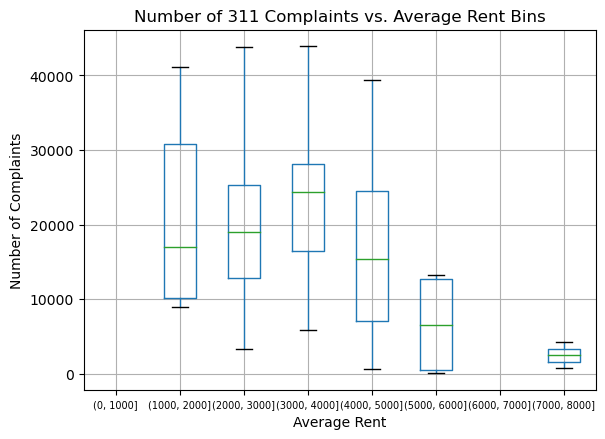

In [22]:
some_dataframe4 = get_data_for_visual_4()
plot_rent_vs_complaints(some_dataframe4)

### Visualization 5

In [ ]:
def plot_recent_311_incidents(dataframe5):
    # Convert WKB to shapely geometries
    dataframe5['geometry'] = dataframe5['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
    # Extract longitude and latitude for each geometry
    dataframe5['longitude'] = dataframe5['geometry'].apply(lambda geom: geom.centroid.x)
    dataframe5['latitude'] = dataframe5['geometry'].apply(lambda geom: geom.centroid.y)

    plt.figure(figsize=(10, 10))
    plt.scatter(dataframe5['longitude'], dataframe5['latitude'], marker='o', color='blue', alpha=0.5)
    plt.title("Recent 311 Incidents in Immediate Area")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

In [9]:
def get_data_for_visual_5():
    V5 = """
    SELECT n.unique_key, n.created_date, n.zipcode, n.complaint_type, z.the_geom
    FROM nyc_311 n
    JOIN zip_codes z ON n.zipcode = z.zipcode
    WHERE n.created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DistanceSphere(z.the_geom, ST_MakePoint(-73.96253174434912,40.80737875669467)) <= 1000;
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V5))
        dataframe5 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe5

In [10]:
some_dataframe5 = get_data_for_visual_5()
plot_recent_311_incidents(some_dataframe5)

NameError: name 'plot_recent_311_incidents' is not defined

### Visualization 6

In [ ]:
def plot_trees_and_complaints(tree_df, complaints_df):   

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    
    temp_tree = tree_df
    temp_complaints = complaints_df
    
    temp_tree['g'] = temp_tree['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
    temp_tree['longitude'] = temp_tree['g'].apply(lambda geom: geom.centroid.x)
    temp_tree['latitude'] = temp_tree['g'].apply(lambda geom: geom.centroid.y)

    temp_complaints['g'] = temp_complaints['the_geom'].apply(lambda x: wkb.loads(binascii.unhexlify(x)))
    temp_complaints['longitude'] = temp_complaints['g'].apply(lambda geom: geom.centroid.x)
    temp_complaints['latitude'] = temp_complaints['g'].apply(lambda geom: geom.centroid.y)
    
    # Scatter plot for trees
    plt.scatter(tree_df['longitude'], tree_df['latitude'], marker='o', color='blue', label='Trees')
    plt.scatter(complaints_df['longitude'], complaints_df['latitude'], marker='x', color='red', label='New Tree Requests')
    
    ax.legend()
    ax.set_title('Trees and New Tree Requests in NYC')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.show()


In [8]:
def get_data_for_visual_6():
    #2018-10-01 to 2023-09-30
    V6_trees = """
    SELECT tree_id, the_geom
    FROM trees;
    """

    V6_complaints = """
    SELECT n.unique_key, n.created_date, n.zipcode, n.complaint_type, z.the_geom
    FROM nyc_311 n
    JOIN zip_codes z ON n.zipcode = z.zipcode
    WHERE n.created_date BETWEEN '2022-10-01' AND '2023-10-01'
    AND complaint_type = 'New Tree Request';
    """

    with engine.connect() as conn:
        trees_result = conn.execute(db.text(V6_trees))
        complaints_result = conn.execute(db.text(V6_complaints))

        trees_df = gpd.GeoDataFrame(trees_result.fetchall(), columns=trees_result.keys())
        complaints_df = gpd.GeoDataFrame(complaints_result.fetchall(), columns=complaints_result.keys())

    return trees_df, complaints_df

In [ ]:
some_trees_df, some_complaints_df = get_data_for_visual_6()  
plot_trees_and_complaints(some_trees_df, some_complaints_df)